# Snake with Q-learning algorithm from HA3

Start with importing packages

In [1]:
# Import the model
import dqn_model

# Import dependencies
import torch
import random
import numpy as np
import gym
from collections import namedtuple
from dqn_model import DoubleQLearningModel, ExperienceReplay

# Set device as cpu/cuda
device = torch.device("cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the greedy policy

In [2]:
def eps_greedy_policy(q_values, eps):
    '''
    Creates an epsilon-greedy policy
    :param q_values: set of Q-values of shape (num actions,)
    :param eps: probability of taking a uniform random action 
    :return: policy of shape (num actions,)
    '''
    
    # YOUR CODE HERE
    policy = np.zeros(len(q_values))
    Pe = random.uniform(0,1)
    
    if(Pe <= eps):
        policy = np.full((len(q_values),), 1/len(q_values))
    else:
        policy[np.argmax(q_values)] = 1
    
    return policy
    

# Prepare the three functions needed for dqn_model

In [3]:
def calc_q_and_take_action(ddqn, state, eps):
    '''
    Calculate Q-values for current state, and take an action according to an epsilon-greedy policy.
    Inputs:
        ddqn   - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        state  - Current state. Numpy array, shape (1, num_states).
        eps    - Exploration parameter.
    Returns:
        q_online_curr   - Q(s,a) for current state s. Numpy array, shape (1, num_actions) or  (num_actions,).
        curr_action     - Selected action (0 or 1, i.e. left or right), sampled from epsilon-greedy policy. Integer.
    '''
    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input, and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).
    
    # YOUR CODE HERE
    
    # Convert the state into a tensor
    torch_state = torch.tensor(state,dtype=torch.float32)
    
    # --------- Online -------- # 
    
    # Compute the Q-values and convert into numpy
    Q_tensor_online = ddqn.online_model(torch_state)  
    q_online_curr = Q_tensor_online.detach().cpu().numpy()
    
    # Compute the policy and convert into tensor
    policy = eps_greedy_policy(q_online_curr, eps)
    
    return q_online_curr, curr_action

In [4]:
def calculate_q_targets(q1_batch, q2_batch, r_batch, nonterminal_batch, gamma=.99):
    '''
    Calculates the Q target used for the loss
    : param q1_batch: Batch of Q(s', a) from online network. FloatTensor, shape (N, num actions)
    : param q2_batch: Batch of Q(s', a) from target network. FloatTensor, shape (N, num actions)
    : param r_batch: Batch of rewards. FloatTensor, shape (N,)
    : param nonterminal_batch: Batch of booleans, with False elements if state s' is terminal and True otherwise. BoolTensor, shape (N,)
    : param gamma: Discount factor, float.
    : return: Q target. FloatTensor, shape (N,)
    '''
    # YOUR CODE HERE
    N = q1_batch.shape[0]
    Y = np.zeros(N)
    
    for i in range(N): 
        
        if nonterminal_batch[i] == True:
            values, a = q1_batch[i,:].max(0)
            Y[i] = r_batch[i] + gamma * q2_batch[i,a]
        
        else: 
            Y[i] = r_batch[i]
    
    Y = torch.tensor(Y,dtype=torch.float32)
    
    return Y

In [5]:
def sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma):
    '''
    Sample mini-batch from replay buffer, and compute the mini-batch loss
    Inputs:
        ddqn          - DDQN model. An object holding the online / offline Q-networks, and some related methods.
        replay_buffer - Replay buffer object (from which smaples will be drawn)
        batch_size    - Batch size
        gamma         - Discount factor
    Returns:
        Mini-batch loss, on which .backward() will be called to compute gradient.
    '''
    # Sample a minibatch of transitions from replay buffer
    curr_state, curr_action, reward, next_state, nonterminal = replay_buffer.sample_minibatch(batch_size)

    # FYI:
    # ddqn.online_model & ddqn.offline_model are Pytorch modules for online / offline Q-networks, which take the state as input, and output the Q-values for all actions.
    # Input shape (batch_size, num_states). Output shape (batch_size, num_actions).

    # YOUR CODE HERE
    
    # Define the q_online_curr
    q_online_curr = ddqn.online_model(curr_state)
    
    # Define the q_online_next
    q_online_next = ddqn.online_model(next_state)      
    
    # Define the q_offline_next
    with torch.no_grad():
        q_offline_next = ddqn.offline_model(next_state)  
    
    
    q_target = calculate_q_targets(q_online_next, q_offline_next, reward, nonterminal, gamma=gamma)
    loss = ddqn.calc_loss(q_online_curr, q_target, curr_action)

    return loss

In [6]:
def train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    eps = 1.
    eps_end = .1 
    eps_decay = .001
    tau = 1000
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    for i in range(num_episodes):
        state = env.reset() # Initial state
        #state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        while not finish_episode:
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1
            #print(steps)
            # Take one step in environment. No need to compute gradients,
            # we will just store transition to replay buffer, and later sample a whole batch
            # from the replay buffer to actually take a gradient step.
            q_online_curr, curr_action = calc_q_and_take_action(ddqn, state, eps)
            q_buffer.append(q_online_curr)
            
            new_state, reward, finish_episode, _ = env.step(curr_action) # take one step in the evironment
            #print(new_state.reshape(5,5))
            #print(reward)
            #print(finish_episode)
            #new_state = new_state[None,:]
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            #print(steps)
            nonterminal_to_buffer = not finish_episode or steps == 2000
            #print(nonterminal_to_buffer)
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                loss = sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma)
                ddqn.optimizer.zero_grad()
                loss.backward()
                ddqn.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    ddqn.update_target_network()
            if steps == 200:
                break
                
        eps = max(eps - eps_decay, eps_end) # decrease epsilon        
        R_buffer.append(ep_reward)
        
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1]) if i > 0 else R_avg.append(R_buffer[i])

        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}'.format(i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer))))
        
        # If running average > 195 (close to 200), the task is considered solved
        if R_avg[-1] > 195:
            return R_buffer, R_avg
    return R_buffer, R_avg

## Setting up the environment

In [7]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [13]:
# Create the environment
env = gym.make("snake5x5-v0")

In [18]:
# Enable visualization? Does not work in all environments.
enable_visualization = False;


# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[1]
num_episodes = 10
batch_size = 8
gamma = .99
learning_rate = 1e-4

# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)

# Create replay buffer, where experience in form of tuples <s,a,r,s',t>, gathered from the environment is stored 
# for training
replay_buffer = ExperienceReplay(device, num_states)



In [19]:
state = env.step(0)
#print(state[0].reshape(9,9))
#print(state[1])
#print(state)

NotImplementedError: 

## Train the network

In [17]:
R, R_avg = train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

NotImplementedError: 

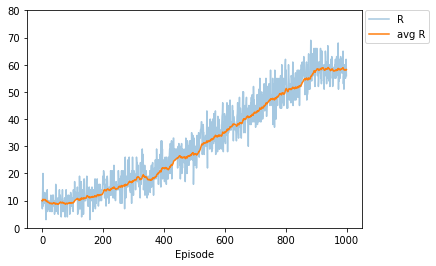

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

rewards = plt.plot(R, alpha=.4, label='R')
avg_rewards = plt.plot(R_avg,label='avg R')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episode')
plt.ylim(0, 80)
plt.show()

Run the cell below for visualizing results.

In [27]:
import time
num_episodes = 10

if True:
    for i in range(num_episodes):
            state = env.reset() #reset to initial state
            state = state[None,:]
            terminal = False # reset terminal flag
            while not terminal:
                env.render()
                time.sleep(.05)
                with torch.no_grad():
                    q_values = ddqn.online_model(torch.tensor(state, dtype=torch.float, device=device)).cpu().numpy()
                policy = eps_greedy_policy(q_values.squeeze(), .1) # greedy policy
                action = np.random.choice(num_actions, p=policy)
                state, reward, terminal, _ = env.step(action) # take one step in the evironment
                state = state[None,:]
    # close window
    env.close();

error: display Surface quit

# DDQN - 11x11 Environment without function approximation

In [8]:
def train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    eps = 1.
    eps_end = .1 
    eps_decay = .001
    tau = 1000
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    for i in range(num_episodes):
        state = env.reset() # Initial state
        #state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        while not finish_episode:
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1
            #print(steps)
            # Take one step in environment. No need to compute gradients,
            # we will just store transition to replay buffer, and later sample a whole batch
            # from the replay buffer to actually take a gradient step.
            q_online_curr, curr_action = calc_q_and_take_action(ddqn, state, eps)
            q_buffer.append(q_online_curr)
            
            new_state, reward, finish_episode, score = env.step(curr_action) # take one step in the evironment
            #print(new_state.reshape(5,5))
            #print(reward)
            #print(finish_episode)
            #new_state = new_state[None,:]
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            #print(steps)
            nonterminal_to_buffer = not finish_episode or steps == 2000
            #print(nonterminal_to_buffer)
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                loss = sample_batch_and_calculate_loss(ddqn, replay_buffer, batch_size, gamma)
                ddqn.optimizer.zero_grad()
                loss.backward()
                ddqn.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    ddqn.update_target_network()
          
        eps = max(eps - eps_decay, eps_end) # decrease epsilon        
        R_buffer.append(ep_reward)
        
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1]) if i > 0 else R_avg.append(R_buffer[i])

        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}, Score {}'.format(i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer)),score))
        
        # If running average > 195 (close to 200), the task is considered solved
        if R_avg[-1] > 195:
            return R_buffer, R_avg
    return R_buffer, R_avg

In [9]:
# Create the environment
env = gym.make("Snake11x11-v0")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
# Enable visualization? Does not work in all environments.
enable_visualization = False;


# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[1]
num_episodes = 10
batch_size = 10
gamma = .94
learning_rate = 1e-4

# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)

# Create replay buffer, where experience in form of tuples <s,a,r,s',t>, gathered from the environment is stored 
# for training
replay_buffer = ExperienceReplay(device, num_states)

In [12]:
R, R_avg = train_loop_ddqn(ddqn, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

Episode: 0, Total Reward (running avg):    4 (4.00) Epsilon: 0.999, Avg Q: 1.277e-07, Score []
Episode: 1, Total Reward (running avg):    4 (4.00) Epsilon: 0.998, Avg Q: 1.333e-07, Score []
Episode: 2, Total Reward (running avg):    4 (4.00) Epsilon: 0.997, Avg Q: 1.531e-07, Score []
Episode: 3, Total Reward (running avg):    4 (4.00) Epsilon: 0.996, Avg Q: 0.001113, Score []
Episode: 4, Total Reward (running avg):    4 (4.00) Epsilon: 0.995, Avg Q: 0.00529, Score []
Episode: 5, Total Reward (running avg):    4 (4.00) Epsilon: 0.994, Avg Q: 0.011, Score []
Episode: 6, Total Reward (running avg):    4 (4.00) Epsilon: 0.993, Avg Q: 0.02011, Score []
Episode: 7, Total Reward (running avg):    5 (4.05) Epsilon: 0.992, Avg Q: 0.01872, Score []
Episode: 8, Total Reward (running avg):    4 (4.05) Epsilon: 0.991, Avg Q: 0.03319, Score []
Episode: 9, Total Reward (running avg):    4 (4.05) Epsilon: 0.990, Avg Q: 0.04295, Score []


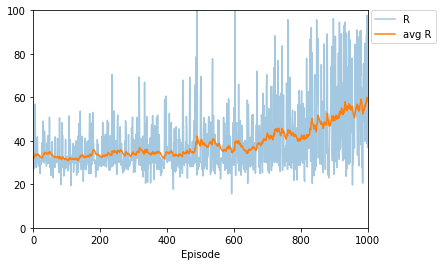

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

rewards = plt.plot(R, alpha=.4, label='R')
avg_rewards = plt.plot(R_avg,label='avg R')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xlabel('Episode')
plt.ylim(0, 100)
plt.xlim(0, 1000)
plt.show()

In [13]:
import time
num_episodes = 10
#env = gym.make("Snake11x11-v0")

if True:
    for i in range(num_episodes):
            state = env.reset() #reset to initial state
            state = state[None,:]
            terminal = False # reset terminal flag
            while not terminal:
                env.render()
                time.sleep(.05)
                with torch.no_grad():
                    q_values = ddqn.online_model(torch.tensor(state, dtype=torch.float, device=device)).cpu().numpy()
                policy = eps_greedy_policy(q_values.squeeze(), .1) # greedy policy
                action = np.random.choice(num_actions, p=policy)
                state, reward, terminal, _ = env.step(action) # take one step in the evironment
                state = state[None,:]
    # close window
    env.close();

error: display Surface quit

# DDQN - 11x11 Environment with function approximation

In [20]:
# Create the environment
env = gym.make("Snake11x11-v0")

Create the neural network which converts the states into a predicted action

In [21]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=256):
        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs,  hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
    
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        return x

In [22]:
num_inputs  = env.observation_space.shape[1]
num_outputs = env.action_space.n
hidden_size = 256

model = Model(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

In [26]:
def train_loop_ddqn(ddqn, model, env, replay_buffer, num_episodes, enable_visualization=False, batch_size=64, gamma=.94):        
    Transition = namedtuple("Transition", ["s", "a", "r", "next_s", "t"])
    eps = 1.
    eps_end = .1 
    eps_decay = .001
    tau = 1000
    cnt_updates = 0
    R_buffer = []
    R_avg = []
    for i in range(num_episodes):
        state = env.reset() # Initial state
        #state = state[None,:] # Add singleton dimension, to represent as batch of size 1.
        finish_episode = False # Initialize
        ep_reward = 0 # Initialize "Episodic reward", i.e. the total reward for episode, when disregarding discount factor.
        q_buffer = []
        steps = 0
        while not finish_episode:
            if enable_visualization:
                env.render() # comment this line out if you don't want to / cannot render the environment on your system
            steps += 1
                    
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = model(state)
            print(q_values)
            q_values = q_values.detach().cpu().numpy()
            print(q_values)
            print(q_values[0])
            
            policy = eps_greedy_policy(q_values[0], eps)
            
            torch_policy = torch.tensor(policy,dtype=torch.float32)
    
            # Compute the action from the policy
            actions = [i for i in range(len(policy))]
            curr_action = random.choices(actions,policy)
    
            # Convert the curr_action into an int
            curr_action = int(curr_action[0])
            #curr_action = dist.sample()
            
            q_buffer.append(q_values[0])
            
            new_state, reward, finish_episode, score = env.step(curr_action) # take one step in the evironment
            #print(new_state.reshape(5,5))
            #print(reward)
            #print(finish_episode)
            #new_state = new_state[None,:]
            
            # Assess whether terminal state was reached.
            # The episode may end due to having reached 200 steps, but we should not regard this as reaching the terminal state, and hence not disregard Q(s',a) from the Q target.
            # https://arxiv.org/abs/1712.00378
            #print(steps)
            nonterminal_to_buffer = not finish_episode or steps == 2000
            #print(nonterminal_to_buffer)
            
            # Store experienced transition to replay buffer
            replay_buffer.add(Transition(s=state, a=curr_action, r=reward, next_s=new_state, t=nonterminal_to_buffer))

            state = new_state
            ep_reward += reward
            
            # If replay buffer contains more than 1000 samples, perform one training step
            if replay_buffer.buffer_length > 1000:
                loss = sample_batch_and_calculate_loss(model, replay_buffer, batch_size, gamma)
                model.optimizer.zero_grad()
                loss.backward()
                model.optimizer.step()

                cnt_updates += 1
                if cnt_updates % tau == 0:
                    model.update_target_network()
          
        eps = max(eps - eps_decay, eps_end) # decrease epsilon        
        R_buffer.append(ep_reward)
        
        # Running average of episodic rewards (total reward, disregarding discount factor)
        R_avg.append(.05 * R_buffer[i] + .95 * R_avg[i-1]) if i > 0 else R_avg.append(R_buffer[i])

        print('Episode: {:d}, Total Reward (running avg): {:4.0f} ({:.2f}) Epsilon: {:.3f}, Avg Q: {:.4g}'.format(i, ep_reward, R_avg[-1], eps, np.mean(np.array(q_buffer))))
        
        # If running average > 195 (close to 200), the task is considered solved
        if R_avg[-1] > 195:
            return R_buffer, R_avg
    return R_buffer, R_avg

In [27]:
# Enable visualization? Does not work in all environments.
enable_visualization = False;


# Initializations
num_actions = env.action_space.n
num_states = env.observation_space.shape[1]
num_episodes = 1000
batch_size = 10
gamma = .94
learning_rate = 1e-4

# Object holding our online / offline Q-Networks
ddqn = DoubleQLearningModel(device, num_states, num_actions, learning_rate)

# Create replay buffer, where experience in form of tuples <s,a,r,s',t>, gathered from the environment is stored 
# for training
replay_buffer = ExperienceReplay(device, num_states)

In [28]:
R, R_avg = train_loop_ddqn(ddqn, model, env, replay_buffer, num_episodes, enable_visualization=enable_visualization, batch_size=batch_size, gamma=gamma)

tensor([[0.0000, 0.0972, 0.0000, 0.0066]], grad_fn=<ReluBackward0>)
[[0.         0.09715915 0.         0.00663432]]
[0.         0.09715915 0.         0.00663432]
tensor([[0.0000, 0.1607, 0.0000, 0.0203]], grad_fn=<ReluBackward0>)
[[0.         0.16073844 0.         0.0203396 ]]
[0.         0.16073844 0.         0.0203396 ]
tensor([[0.0000, 0.0394, 0.0000, 0.0325]], grad_fn=<ReluBackward0>)
[[0.         0.03942755 0.         0.03247177]]
[0.         0.03942755 0.         0.03247177]
tensor([[0.0000, 0.1708, 0.0365, 0.0173]], grad_fn=<ReluBackward0>)
[[0.         0.17081125 0.03646655 0.01730601]]
[0.         0.17081125 0.03646655 0.01730601]
tensor([[0.0000, 0.0557, 0.0085, 0.0581]], grad_fn=<ReluBackward0>)
[[0.         0.05569209 0.00849248 0.05805771]]
[0.         0.05569209 0.00849248 0.05805771]
tensor([[0.0000, 0.0874, 0.0000, 0.0786]], grad_fn=<ReluBackward0>)
[[0.         0.08744999 0.         0.07864934]]
[0.         0.08744999 0.         0.07864934]
tensor([[0.0000, 0.1653, 0.0

[[0.01917358 0.06182375 0.         0.01619397]]
[0.01917358 0.06182375 0.         0.01619397]
tensor([[0.0000, 0.1261, 0.0000, 0.0550]], grad_fn=<ReluBackward0>)
[[0.         0.12605864 0.         0.05504212]]
[0.         0.12605864 0.         0.05504212]
tensor([[0.0000, 0.1446, 0.0314, 0.0366]], grad_fn=<ReluBackward0>)
[[0.         0.14460108 0.03135077 0.03662673]]
[0.         0.14460108 0.03135077 0.03662673]
tensor([[0.0000, 0.2069, 0.0298, 0.0682]], grad_fn=<ReluBackward0>)
[[0.         0.20691708 0.02981114 0.06819324]]
[0.         0.20691708 0.02981114 0.06819324]
tensor([[0.0000, 0.1504, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
[[0.         0.15035668 0.         0.        ]]
[0.         0.15035668 0.         0.        ]
tensor([[0.0006, 0.0929, 0.0000, 0.0224]], grad_fn=<ReluBackward0>)
[[0.00058616 0.09289595 0.         0.02235676]]
[0.00058616 0.09289595 0.         0.02235676]
tensor([[0.0044, 0.0580, 0.0000, 0.0040]], grad_fn=<ReluBackward0>)
[[0.00440502 0.05799954 0.  

[[0.         0.17775461 0.01167174 0.12592685]]
[0.         0.17775461 0.01167174 0.12592685]
tensor([[0.0000, 0.1149, 0.0000, 0.1544]], grad_fn=<ReluBackward0>)
[[0.         0.11492743 0.         0.15440339]]
[0.         0.11492743 0.         0.15440339]
tensor([[0.0000, 0.0999, 0.0000, 0.0570]], grad_fn=<ReluBackward0>)
[[0.         0.09990527 0.         0.05696299]]
[0.         0.09990527 0.         0.05696299]
tensor([[0.0000, 0.1602, 0.0000, 0.1174]], grad_fn=<ReluBackward0>)
[[0.         0.16024166 0.         0.11744191]]
[0.         0.16024166 0.         0.11744191]
tensor([[0.0000, 0.1498, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
[[0.        0.1497837 0.        0.       ]]
[0.        0.1497837 0.        0.       ]
tensor([[0.0000, 0.1739, 0.0057, 0.0211]], grad_fn=<ReluBackward0>)
[[0.         0.17394528 0.00569118 0.02105635]]
[0.         0.17394528 0.00569118 0.02105635]
tensor([[0.0000, 0.1956, 0.0803, 0.0000]], grad_fn=<ReluBackward0>)
[[0.         0.19564575 0.08025876 0

tensor([[0.0000, 0.2240, 0.0000, 0.0874]], grad_fn=<ReluBackward0>)
[[0.        0.2239669 0.        0.0873535]]
[0.        0.2239669 0.        0.0873535]
tensor([[0.0000, 0.2733, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
[[0.        0.2732876 0.        0.       ]]
[0.        0.2732876 0.        0.       ]
tensor([[0.0000, 0.2174, 0.0035, 0.0994]], grad_fn=<ReluBackward0>)
[[0.         0.21740313 0.00349366 0.09943856]]
[0.         0.21740313 0.00349366 0.09943856]
Episode: 0, Total Reward (running avg):    4 (4.00) Epsilon: 0.999, Avg Q: 0.04925
tensor([[0.0000, 0.1161, 0.0000, 0.0099]], grad_fn=<ReluBackward0>)
[[0.         0.11605339 0.         0.0099329 ]]
[0.         0.11605339 0.         0.0099329 ]
tensor([[0.0000, 0.1360, 0.0000, 0.0671]], grad_fn=<ReluBackward0>)
[[0.         0.13599235 0.         0.06707342]]
[0.         0.13599235 0.         0.06707342]
tensor([[0.0000, 0.0161, 0.0000, 0.0183]], grad_fn=<ReluBackward0>)
[[0.         0.01608684 0.         0.01833603]]
[0.    

[[0.         0.17591913 0.05066484 0.06772557]]
[0.         0.17591913 0.05066484 0.06772557]
tensor([[0.0000, 0.0000, 0.0365, 0.1245]], grad_fn=<ReluBackward0>)
[[0.         0.         0.03650808 0.1245328 ]]
[0.         0.         0.03650808 0.1245328 ]
tensor([[0.0000, 0.1427, 0.0000, 0.0123]], grad_fn=<ReluBackward0>)
[[0.         0.14274877 0.         0.0122704 ]]
[0.         0.14274877 0.         0.0122704 ]
tensor([[0.0000, 0.1798, 0.0000, 0.1103]], grad_fn=<ReluBackward0>)
[[0.         0.17975534 0.         0.11026195]]
[0.         0.17975534 0.         0.11026195]
tensor([[0.0000, 0.1759, 0.0507, 0.0677]], grad_fn=<ReluBackward0>)
[[0.         0.17591913 0.05066484 0.06772557]]
[0.         0.17591913 0.05066484 0.06772557]
tensor([[0.0000, 0.0000, 0.0000, 0.1632]], grad_fn=<ReluBackward0>)
[[0.         0.         0.         0.16321371]]
[0.         0.         0.         0.16321371]
tensor([[0.0000, 0.0410, 0.0000, 0.1125]], grad_fn=<ReluBackward0>)
[[0.         0.04103263 0.  

tensor([[0.0000, 0.2410, 0.0000, 0.0202]], grad_fn=<ReluBackward0>)
[[0.         0.24097365 0.         0.02021137]]
[0.         0.24097365 0.         0.02021137]
tensor([[0.0000, 0.1381, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
[[0.        0.1380648 0.        0.       ]]
[0.        0.1380648 0.        0.       ]
tensor([[0.0000, 0.2464, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
[[0.         0.24639873 0.         0.        ]]
[0.         0.24639873 0.         0.        ]
tensor([[0.0000, 0.2815, 0.0000, 0.0399]], grad_fn=<ReluBackward0>)
[[0.         0.281532   0.         0.03993695]]
[0.         0.281532   0.         0.03993695]
tensor([[0.0000, 0.1516, 0.0000, 0.1594]], grad_fn=<ReluBackward0>)
[[0.         0.15155989 0.         0.15935817]]
[0.         0.15155989 0.         0.15935817]
tensor([[0.0000, 0.0012, 0.0000, 0.1743]], grad_fn=<ReluBackward0>)
[[0.         0.00121999 0.         0.1742563 ]]
[0.         0.00121999 0.         0.1742563 ]
tensor([[0.0000, 0.0000, 0.0000, 0.2

AttributeError: 'Model' object has no attribute 'online_model'